# BASIC CONFIG

In [1]:
# https://www.kaggle.com/competitions/home-credit-default-risk

import os
import pandas as pd
import numpy as np
import pandasql as psql
from pandasql import sqldf

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import shap

import sklearn
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from aux_functions import sqllite_query
sqllite_db = 'SQLITE/sqlite3.db'


conn = sqlite3.connect(sqllite_db, timeout = 5)
engine = sqlalchemy.create_engine(f'sqlite:///{sqllite_db}', echo=False)


from aux_functions import draw_roc_curve, draw_precision_recall_curves, draw_precision_recall_area
from aux_functions import draw_confusion_matrix, z_score_pandas_df, draw_lift_curve, draw_score_vs_target_bins

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

pysqldf = lambda q: sqldf(q, globals())

bln_load_app_train_only = True

D:\Anaconda\envs\HC_Kaggle_Credit_Risk\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LOAD DATA

In [2]:
sql = """select * from application_train"""
df_app_train = sqllite_query(sqllite_db, sql, bln_read_results_to_df = True)
df_app_train['DATA_TYPE'] = 'MODEL'
df_app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DATA_TYPE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,MODEL
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,MODEL
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [3]:
sql = """select * from application_test"""
df_app_test = sqllite_query(sqllite_db, sql, bln_read_results_to_df = True)

df_app_test.insert(loc = 1, column = 'TARGET', value = np.nan)
df_app_test['DATA_TYPE'] = 'SUBMISSION'
df_app_test.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DATA_TYPE
0,100001,NaN,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,None,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.066,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,None,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,SUBMISSION
1,100005,NaN,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,SUBMISSION
2,100013,NaN,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,None,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,SUBMISSION


In [4]:
df_app = pd.concat([df_app_train, df_app_test])

In [5]:
sql = """select * from features_prev_app_agg"""
df_fpaa = sqllite_query(sqllite_db, sql, bln_read_results_to_df = True)
df_fpaa.head(3)

,SK_ID_CURR,prev_cnt_apps,prev_cnt_consumer_apps,prev_cnt_cash_apps,prev_cnt_revolving_apps,prev_cnt_loans,prev_cnt_consumer_loans,prev_cnt_cash_loans,prev_cnt_revolving_loans,prev_last_app_amt_credit,prev_last_app_name_contract_status,prev_last_app_days_decision,prev_last_app_name_client_type,prev_last_app_name_contract_type,prev_last_app_product_combination,prev_first_app_amt_credit,prev_first_app_name_contract_status,prev_first_app_days_decision,prev_first_app_name_client_type,prev_first_app_name_contract_type,prev_first_app_product_combination,prev_last_loan_amt_credit,prev_last_loan_days_decision,prev_last_loan_days_first_due,prev_last_loan_days_last_due,prev_last_loan_days_termination,prev_last_loan_rate_interest,prev_first_loan_amt_credit,prev_first_loan_days_decision,prev_first_loan_days_first_due,prev_first_loan_days_termination,prev_first_loan_rate_interest,prev_max_min_amt_credit,prev_max_min_days_decision,prev_max_min_rate_interest
0,100001,1,1,0,0,1,1,0,0,23787.0,Approved,-1740,Refreshed,Consumer loans,POS mobile with interest,23787.0,Approved,-1740,Refreshed,Consumer loans,POS mobile with interest,23787.0,-1740.0,-1709.0,-1619.0,-1612.0,0.814646,23787.0,-1740.0,-1709.0,-1612.0,0.814646,0.0,0,0.00000
1,100002,1,1,0,0,1,1,0,0,179055.0,Approved,-606,New,Consumer loans,POS other with interest,179055.0,Approved,-606,New,Consumer loans,POS other with interest,179055.0,-606.0,-565.0,-25.0,-17.0,0.215780,179055.0,-606.0,-565.0,-17.0,0.215780,0.0,0,0.00000
2,100003,3,2,1,0,3,2,1,0,1035882.0,Approved,0,Repeater,Cash loans,Cash X-Sell: low,68053.5,Approved,0,Refreshed,Consumer loans,POS household with interest,1035882.0,-746.0,-716.0,-536.0,-527.0,0.248058,68053.5,-2341.0,-2310.0,-1976.0,0.330635,967828.5,1595,0.12375


In [6]:
sql = """select * from features_bureau_agg"""
df_fba = sqllite_query(sqllite_db, sql, bln_read_results_to_df = True)
df_fba.head(3)

,SK_ID_CURR,bur_cnt_credit,bur_cnt_credit_closed,bur_cnt_credit_active,bur_cnt_credit_overdue,bur_max_days_credit,bur_min_days_credit,bur_max_days_credit_enddate,bur_min_days_credit_enddate,bur_sum_amt_credit_sum_debt,bur_min_amt_credit_sum_debt,bur_max_amt_credit_sum_debt,bur_max_min_amt_credit_sum_debt,bur_cnt_credit_30,bur_cnt_credit_90,bur_cnt_credit_180,bur_cnt_credit_360
0,100001,7,4,3,0,-49,-1572,1778.0,-1329.0,596686.5,0.0,373239.0,373239.0,0,1,1,2
1,100002,8,6,2,0,-103,-1437,780.0,-1072.0,245781.0,0.0,245781.0,245781.0,0,0,1,1
2,100003,4,3,1,0,-606,-2586,1216.0,-2434.0,0.0,0.0,0.0,0.0,0,0,0,0


In [7]:
df = pd.merge(df_app, df_fpaa, on='SK_ID_CURR', how='left', validate ="1:1")

In [8]:
df = pd.merge(df, df_fba, on='SK_ID_CURR', how='left', validate ="1:1")

In [ ]:
df.dtypes

# DATA

In [9]:
# Basic feature engineering

def basic_feature_engineering(df):

    # convert days birth to AGE in years
    df['AGE'] = df['DAYS_BIRTH']/(-365)
    df['AGE'] = df['AGE'].astype('int64')

    df.drop('DAYS_BIRTH', axis=1, inplace=True)


    # convert regions to categorical
    col_region_list = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
    df[col_region_list] = df[col_region_list].astype("category")


    # optional service amount
    df['AMT_OSER'] = df['AMT_CREDIT']-df['AMT_GOODS_PRICE']


    # credit to annuity ratio
    df['RAT_CREDIT_ANNUITY'] = df['AMT_CREDIT']/df['AMT_ANNUITY']


    # default rate in social circle
    df['RATE_DEF_30_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE']/df['OBS_30_CNT_SOCIAL_CIRCLE']
    df['RATE_DEF_60_SOCIAL_CIRCLE'] = df['DEF_60_CNT_SOCIAL_CIRCLE']/df['OBS_60_CNT_SOCIAL_CIRCLE']


    # credit bureau debt to credit amount ratio
    df['RAT_BUREAU_DEBT_AMT_CREDIT'] = df['bur_sum_amt_credit_sum_debt']/df['AMT_CREDIT']
    
    return df


def transform_dataframe(df):
    # keep only numeric columns
    #df = df.select_dtypes(include=np.number) 

    # drop all nas
    #df = df.dropna() 

    # inpute mean values
    #df = df.fillna(df.mean()) 

    # z-score transform numerical inputs
    #dfz = z_score_pandas_df(df, excl_col=['SK_ID_CURR', 'TARGET'])

    # convert all text values to categorical type
    cat_list = df.select_dtypes(include=np.object).columns.values.tolist()
    df[cat_list] = df[cat_list].astype("category")

    # create one-hot encoding dummies and remove original variables
    df = pd.get_dummies(df)
    
    return df

In [10]:
# Run some basic transformation
df = basic_feature_engineering(df)
df = transform_dataframe(df)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# SPLIT THE SAMPLE

In [108]:
from sklearn.model_selection import train_test_split

df_model = df.query("DATA_TYPE_MODEL == 1")
df_sub = df.query("DATA_TYPE_SUBMISSION == 1")

X = df_model.drop('TARGET', axis=1)
y = df_model['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, train_size = 0.7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=123, train_size=0.8)
X_sub = df_sub.drop('TARGET', axis=1)

print(f"""

Train data size: {X_train.shape[0]}, {X_train.shape[1]}
Valid data size: {X_valid.shape[0]}, {X_valid.shape[1]} 
Test data size: {X_test.shape[0]}, {X_test.shape[1]} 
Submission data size: {X_sub.shape[0]}, {X_sub.shape[1]} 

Train mean target: {y_train.mean():.2%}
Valid mean target: {y_valid.mean():.2%}
Test mean target: {y_test.mean():.2%}

Train # bads {y_train.sum()}
Valid # bads {y_valid.sum()}
Test # bads {y_test.sum()}

""")



Train data size: 172205, 357
Valid data size: 43052, 357 
Test data size: 92254, 357 
Submission data size: 48744, 357 

Train mean target: 8.02%
Valid mean target: 8.09%
Test mean target: 8.17%

Train # bads 13807.0
Valid # bads 3481.0
Test # bads 7537.0




# MODELLING

# NAIVE BAYES

In [ ]:
# NAIVE BAYES

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_model = model.predict(X_test)

In [ ]:
y_model.sum()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_model)

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

In [ ]:
# Leave one out validation - runs too long un such a big dataset
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
print(scores.mean())

In [ ]:
draw_roc_curve(model, X_test, y_test)

In [ ]:
draw_precision_recall_curves(model, X_test, y_test)

In [ ]:
draw_confusion_matrix(model, X_test, y_test, labels=['GOOD','BAD'])

# LOGISTIC REGRESSION

# SVM

# TREE

# XGB

In [105]:
import os
os.cpu_count()

8

In [148]:
model = xgb.XGBClassifier(objective="binary:logistic", 
                          scale_pos_weight=1, # set higher value for imbalanced datasets
                          max_depth=4,
                          n_estimators=1000,
                          learning_rate=0.1,
                          early_stopping_rounds=5,
                          eval_metric='auc',
                          n_jobs=6
                          
                         
                         )
#model.fit(X_train, y_train)


model.fit(X_train, y_train,
          eval_set=[(X_train, y_train),
                    (X_valid, y_valid)
                   ]
          )

[0]	validation_0-auc:0.70239	validation_1-auc:0.69861
[1]	validation_0-auc:0.70924	validation_1-auc:0.70432
[2]	validation_0-auc:0.71188	validation_1-auc:0.70708
[3]	validation_0-auc:0.71449	validation_1-auc:0.70887
[4]	validation_0-auc:0.71636	validation_1-auc:0.70991
[5]	validation_0-auc:0.71774	validation_1-auc:0.71184
[6]	validation_0-auc:0.71859	validation_1-auc:0.71202
[7]	validation_0-auc:0.71944	validation_1-auc:0.71280
[8]	validation_0-auc:0.72086	validation_1-auc:0.71388
[9]	validation_0-auc:0.72269	validation_1-auc:0.71555
[10]	validation_0-auc:0.72290	validation_1-auc:0.71576
[11]	validation_0-auc:0.72464	validation_1-auc:0.71692
[12]	validation_0-auc:0.72530	validation_1-auc:0.71775
[13]	validation_0-auc:0.72666	validation_1-auc:0.71866
[14]	validation_0-auc:0.72745	validation_1-auc:0.71899
[15]	validation_0-auc:0.72833	validation_1-auc:0.71947
[16]	validation_0-auc:0.72999	validation_1-auc:0.72101
[17]	validation_0-auc:0.73137	validation_1-auc:0.72210
[18]	validation_0-au

[149]	validation_0-auc:0.80318	validation_1-auc:0.76971
[150]	validation_0-auc:0.80341	validation_1-auc:0.76967
[151]	validation_0-auc:0.80375	validation_1-auc:0.76982
[152]	validation_0-auc:0.80409	validation_1-auc:0.77013
[153]	validation_0-auc:0.80432	validation_1-auc:0.77030
[154]	validation_0-auc:0.80457	validation_1-auc:0.77047
[155]	validation_0-auc:0.80485	validation_1-auc:0.77059
[156]	validation_0-auc:0.80507	validation_1-auc:0.77056
[157]	validation_0-auc:0.80530	validation_1-auc:0.77066
[158]	validation_0-auc:0.80541	validation_1-auc:0.77070
[159]	validation_0-auc:0.80567	validation_1-auc:0.77080
[160]	validation_0-auc:0.80583	validation_1-auc:0.77072
[161]	validation_0-auc:0.80617	validation_1-auc:0.77089
[162]	validation_0-auc:0.80643	validation_1-auc:0.77092
[163]	validation_0-auc:0.80663	validation_1-auc:0.77093
[164]	validation_0-auc:0.80683	validation_1-auc:0.77090
[165]	validation_0-auc:0.80706	validation_1-auc:0.77087
[166]	validation_0-auc:0.80716	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=6, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [149]:
y_model = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [150]:
model.save_model("MODELS/xgb_model.json")

In [151]:
y_model.sum()

286

In [152]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_model)

0.9187135517159147

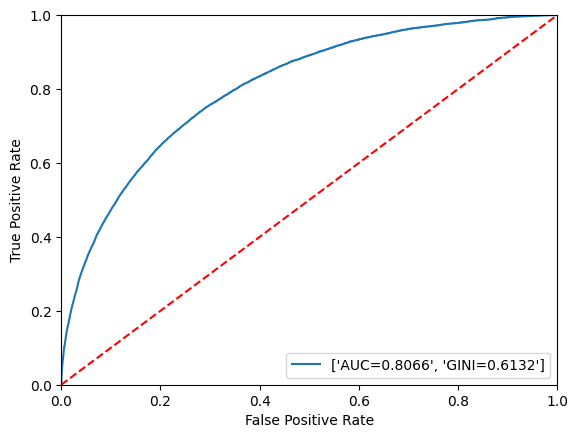

In [153]:
draw_roc_curve(model, X_train, y_train)

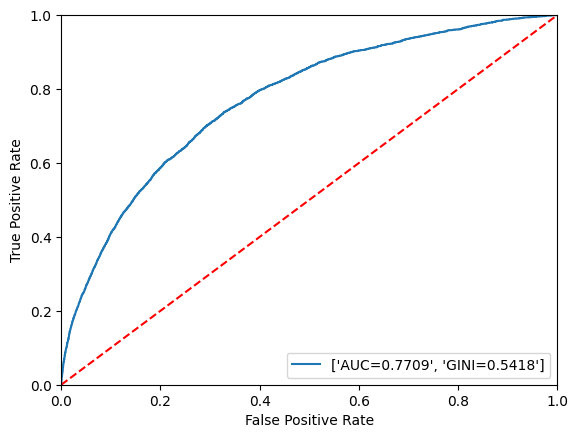

In [154]:
draw_roc_curve(model, X_valid, y_valid)

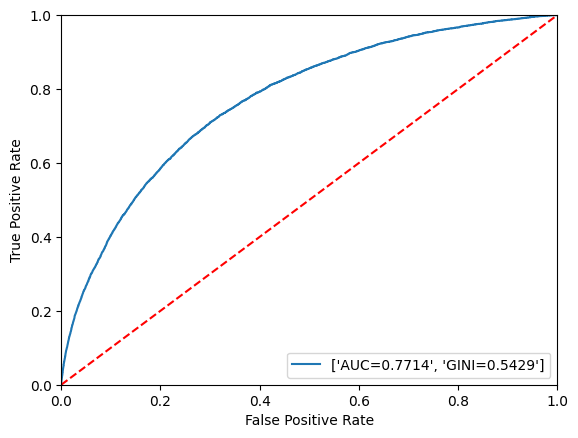

In [155]:
draw_roc_curve(model, X_test, y_test)

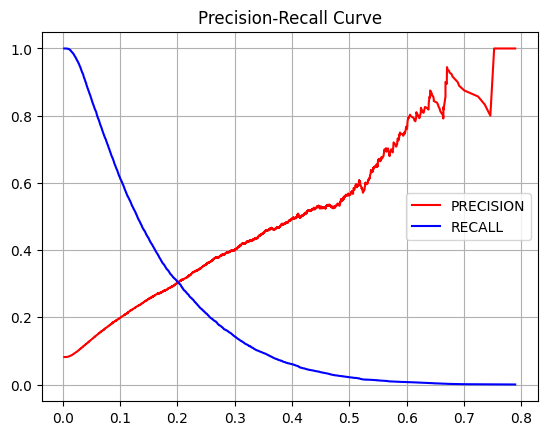

In [156]:
draw_precision_recall_curves(model, X_test, y_test)

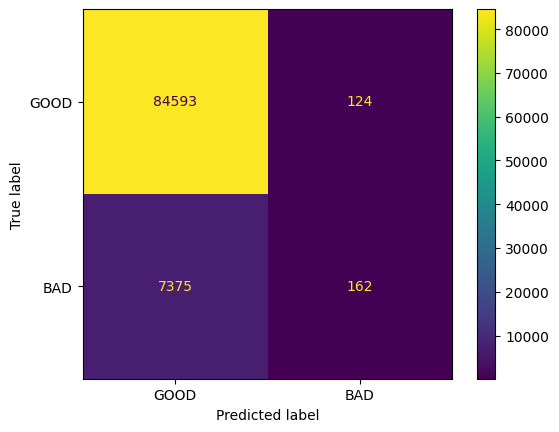

In [157]:
draw_confusion_matrix(model, X_test, y_test, labels=['GOOD','BAD'])

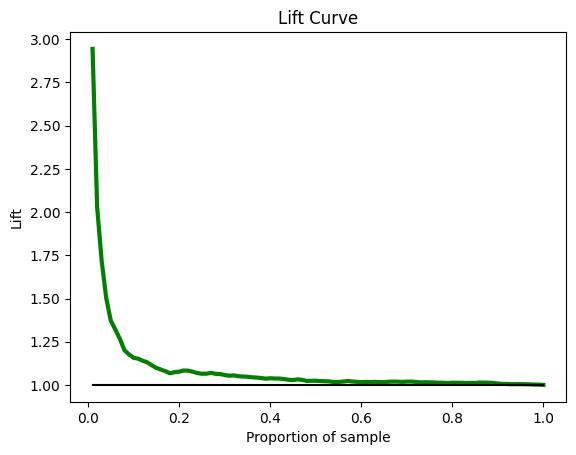

In [158]:
draw_lift_curve(y_test, y_model)

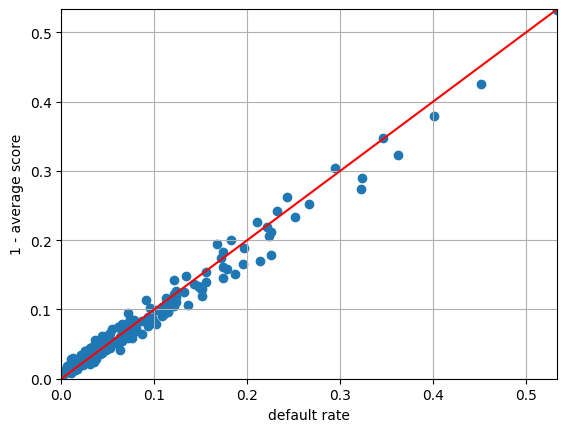

In [159]:
draw_score_vs_target_bins(y_proba[:,1], y_test, bins=200)

# XGB with k-fold evaluation

In [27]:
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
model = xgb.XGBClassifier(objective="binary:logistic")

In [28]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

NameError: name 'mean' is not defined

In [29]:
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.75663


# SHAP

In [ ]:
shap.initjs() # # load JS visualization code to notebook

In [ ]:
X_sampled = X_train.sample(100, random_state=10)

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
# SOURCE: https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sampled)

In [ ]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

In [ ]:
shap.dependence_plot('AMT_CREDIT', shap_values, X_sampled)

In [ ]:
shap.dependence_plot('EXT_SOURCE_3', shap_values, X_sampled)

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

In [ ]:
shap.plots.beeswarm(shap_values, X_sampled)

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar", max_display=10)

In [ ]:
shap.plots.waterfall(shap_values[0])

# SCORE THE TEST DATA

In [160]:
xbg_model = xgb.XGBClassifier()

xbg_model.load_model("MODELS/xgb_model.json")

In [161]:
y_sub = xbg_model.predict_proba(X_sub)

In [162]:
#y_sub = pd.DataFrame(y_sub)
y_sub = pd.DataFrame(y_sub[:,1])
y_sub.columns = ['TARGET']

In [163]:
df_sub_final = pd.merge(X_sub[['SK_ID_CURR']].reset_index(drop=True), y_sub, left_index=True, right_index=True)
df_sub_final.describe()

,SK_ID_CURR,TARGET
count,48744.000000,48744.000000
mean,277796.676350,0.079093
std,103169.547296,0.079168
min,100001.000000,0.003058
25%,188557.750000,0.028112
50%,277549.000000,0.051371
75%,367555.500000,0.100397
max,456250.000000,0.812436


In [164]:
df_sub_final.to_csv('df_sub_final_proba_20230228_4.csv', index=False)